In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback

import progressbar

Using TensorFlow backend.


In [2]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        if len(text) > 3:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [3]:
data_list = read_data('../data/')

print data_list[0]

# data_list = data_list[:3000]

train_test_cutoff = int(.70 * len(data_list)) 
training_sentences = data_list[:train_test_cutoff]
testing_sentences = data_list[train_test_cutoff:]
 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

[('A', 'NA'), ('Hybrid', 'NA'), ('Photoreceptor', 'NA'), ('Expressing', 'NA'), ('Both', 'NA'), ('Rod', 'NA'), ('and', 'NA'), ('Cone', 'NA'), ('Genes', 'NA'), ('in', 'NA'), ('a', 'NA'), ('Mouse', 'NA'), ('Model', 'NA'), ('of', 'NA'), ('Enhanced', 'NA'), ('SCone', 'NA'), ('Syndrome', 'NA')]


In [4]:
print training_sentences[0]

[('Click', 'NA'), ('here', 'NA'), ('for', 'NA'), ('additional', 'NA'), ('data', 'NA'), ('file', 'NA')]


In [5]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
 
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """

    term = sentence_terms[index]

    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [6]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 
 
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]
 
def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
 
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
 
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

In [7]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [8]:
from sklearn.feature_extraction import DictVectorizer
 
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [9]:
# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

In [10]:
# Fit LabelEncoder with our list of classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

In [11]:
# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [12]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(198618, 90047) (112173, 90047) (198618, 104) (112173, 104)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
 
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
# from keras.callbacks import Callback
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# import numpy as np

# class Metrics(Callback):

#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []

#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
#         val_targ = self.model.validation_data[1]
#         _val_f1 = f1_score(val_targ, val_predict)
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
#         self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print " — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall)
#         return

# metrics = Metrics()

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
 
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}
 
clf = KerasClassifier(**model_params)

In [21]:
hist = clf.fit(X_train, y_train)

Train on 198618 samples, validate on 57828 samples
Epoch 1/5


InternalError: Dst tensor is not initialized.
	 [[Node: Const_97 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [90047,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'Const_97', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sdmohant/.virtualenvs/deeplearn/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-370f54593e4a>", line 6, in <module>
    hist = clf.fit(X_train, y_train)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/wrappers/scikit_learn.py", line 206, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/wrappers/scikit_learn.py", line 149, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/models.py", line 870, in fit
    initial_epoch=initial_epoch)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/engine/training.py", line 1490, in fit
    self._make_train_function()
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/engine/training.py", line 1014, in _make_train_function
    self.total_loss)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/optimizers.py", line 417, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 601, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape),
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py", line 162, in __call__
    verify_shape=self.verify_shape)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Dst tensor is not initialized.
	 [[Node: Const_97 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [90047,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
 
    green = '#72C29B'
    orange = '#FFA577'
 
    with plt.xkcd():
        # plot model loss
        fig, ax1 = plt.subplots()
        ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        # plot model accuracy
        fig, ax2 = plt.subplots()
        ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


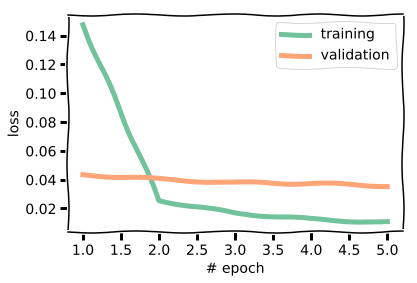

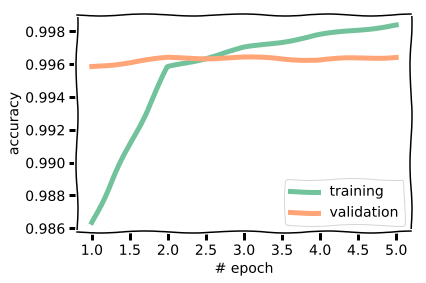

In [18]:
# Plot model performance
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [19]:
score = clf.score(X_test, y_test)
print(score)

72192/72251 [============================>.] - ETA: 0s0.997979266723


In [22]:
from sklearn.metrics import classification_report


predicted = clf.predict(X_test)
predicted_cat = np_utils.to_categorical(predicted)
report = classification_report(y_test, predicted_cat, target_names=label_encoder.classes_)
print "\n"
print report

72192/72251 [============================>.] - ETA: 0s

             precision    recall  f1-score   support

 GO:0000267       0.00      0.00      0.00         0
 GO:0000502       0.00      0.00      0.00         0
 GO:0000775       0.00      0.00      0.00         0
 GO:0000785       1.00      1.00      1.00         6
 GO:0000786       0.00      0.00      0.00         0
 GO:0000791       0.00      0.00      0.00         0
 GO:0000792       0.00      0.00      0.00         0
 GO:0000795       0.00      0.00      0.00         0
 GO:0000805       0.00      0.00      0.00         0
 GO:0000806       0.00      0.00      0.00         0
 GO:0001917       0.00      0.00      0.00         0
 GO:0005575       0.00      0.00      0.00         0
 GO:0005576       0.00      0.00      0.00         0
 GO:0005577       0.00      0.00      0.00         0
 GO:0005581       1.00      1.00      1.00         1
 GO:0005622       0.00      0.00      0.00         0
 GO:0005623       0.99      1.00      1.00

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, predicted_cat)

plot_confusion_matrix(cnf_matrix, target_names=label_encoder.classes_, title='Confusion matrix, without normalization')

ValueError: multilabel-indicator is not supported